In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import shap
import joblib
import os


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_PATH = "/Users/tagesehandiso/insurance_analytics_storage/MachineLearningRating_v3.txt"  # Ensure this path is correct
df = pd.read_csv(DATA_PATH, sep='|', low_memory=False)
df.shape, df.columns


((1000098, 52),
 Index(['UnderwrittenCoverID', 'PolicyID', 'TransactionMonth',
        'IsVATRegistered', 'Citizenship', 'LegalType', 'Title', 'Language',
        'Bank', 'AccountType', 'MaritalStatus', 'Gender', 'Country', 'Province',
        'PostalCode', 'MainCrestaZone', 'SubCrestaZone', 'ItemType', 'mmcode',
        'VehicleType', 'RegistrationYear', 'make', 'Model', 'Cylinders',
        'cubiccapacity', 'kilowatts', 'bodytype', 'NumberOfDoors',
        'VehicleIntroDate', 'CustomValueEstimate', 'AlarmImmobiliser',
        'TrackingDevice', 'CapitalOutstanding', 'NewVehicle', 'WrittenOff',
        'Rebuilt', 'Converted', 'CrossBorder', 'NumberOfVehiclesInFleet',
        'SumInsured', 'TermFrequency', 'CalculatedPremiumPerTerm',
        'ExcessSelected', 'CoverCategory', 'CoverType', 'CoverGroup', 'Section',
        'Product', 'StatutoryClass', 'StatutoryRiskType', 'TotalPremium',
        'TotalClaims'],
       dtype='object'))

In [3]:
# Remove rows with missing or zero TotalPremium
df = df[df['TotalPremium'].notna() & (df['TotalPremium'] > 0)]

# Create binary target for claim occurrence
df['HasClaim'] = df['TotalClaims'] > 0

# One-hot encode categorical features
categorical_cols = df.select_dtypes(include='object').columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Fill missing values
df = df.fillna(0)


In [4]:
severity_df = df[df['HasClaim'] == True]
X_sev = severity_df.drop(columns=['TotalClaims', 'HasClaim'])
y_sev = severity_df['TotalClaims']

X_train_sev, X_test_sev, y_train_sev, y_test_sev = train_test_split(
    X_sev, y_sev, test_size=0.2, random_state=42)


In [5]:
rf_sev = RandomForestRegressor(n_estimators=100, random_state=42)
rf_sev.fit(X_train_sev, y_train_sev)

y_pred_sev = rf_sev.predict(X_test_sev)

print("RMSE:", np.sqrt(mean_squared_error(y_test_sev, y_pred_sev)))
print("R^2:", r2_score(y_test_sev, y_pred_sev))

# Save the model to a subdirectory
os.makedirs("models", exist_ok=True)
joblib.dump(rf_sev, "models/task_4_claim_severity_model.pkl")


RMSE: 26970.79669862695
R^2: 0.2668779341763804


['models/task_4_claim_severity_model.pkl']

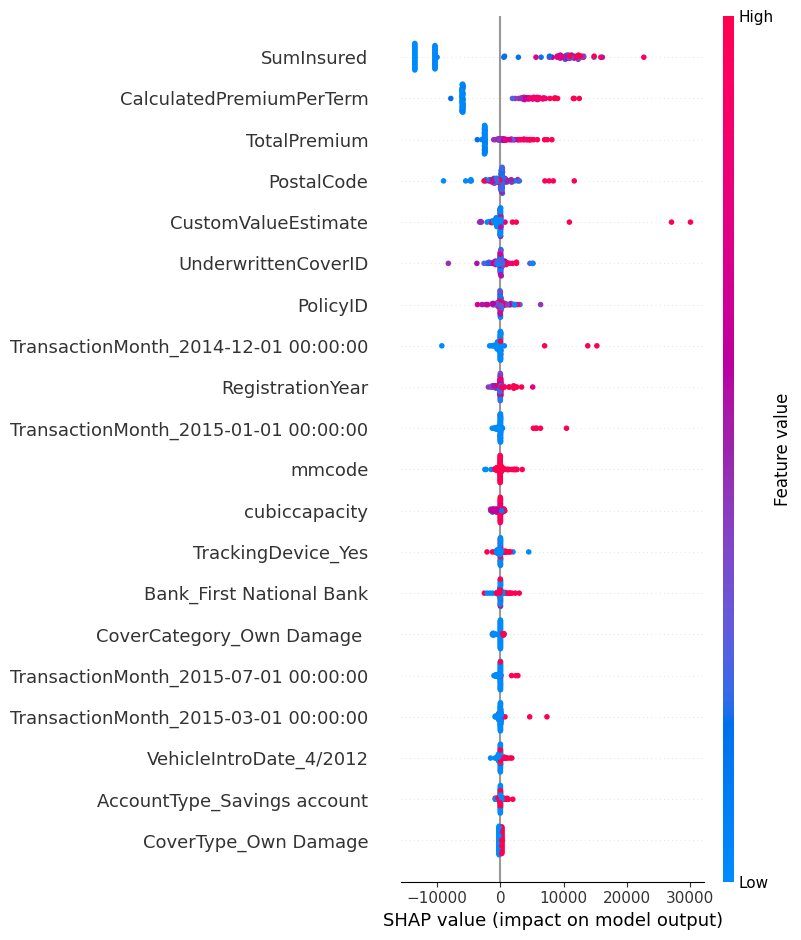

In [6]:
# Convert boolean columns to integers
X_test_sev_numeric = X_test_sev.copy()
bool_cols = X_test_sev_numeric.select_dtypes(include='bool').columns
X_test_sev_numeric[bool_cols] = X_test_sev_numeric[bool_cols].astype(int)

# Sample for faster SHAP
sample = X_test_sev_numeric.sample(100, random_state=42)

explainer = shap.TreeExplainer(rf_sev)
shap_values = explainer.shap_values(sample, approximate=True, check_additivity=False)

shap.summary_plot(shap_values, sample)


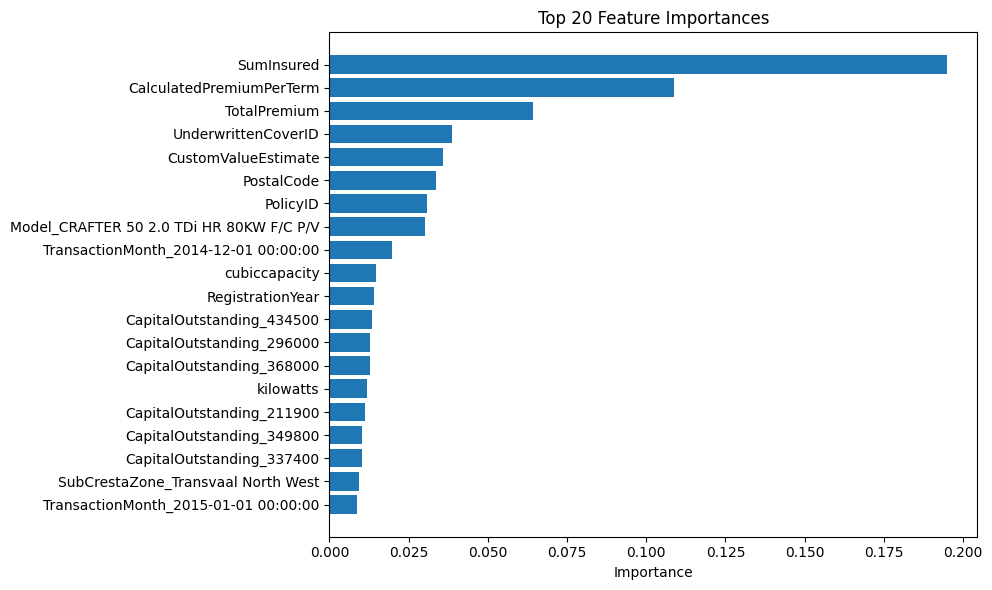

In [8]:
importances = rf_sev.feature_importances_
features = X_sev.columns
indices = np.argsort(importances)[-20:]  # Top 20

plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.title("Top 20 Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()
